In [ ]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [124]:
img = cv2.imread('E:/Internship project/model/test_images/sharapova1.jpg')
img.shape

(555, 700, 3)

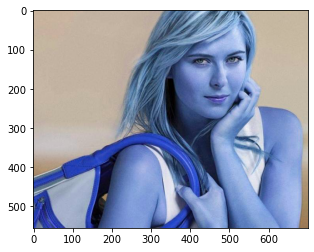

In [125]:
plt.imshow(img)

In [126]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(555, 700)

In [127]:
gray

array([[175, 175, 175, ..., 176, 175, 174],
       [175, 175, 175, ..., 177, 175, 174],
       [175, 175, 175, ..., 177, 176, 174],
       ...,
       [ 84,  87,  88, ..., 113, 113, 113],
       [ 88,  89,  90, ..., 113, 113, 113],
       [ 93,  91,  91, ..., 112, 112, 112]], dtype=uint8)

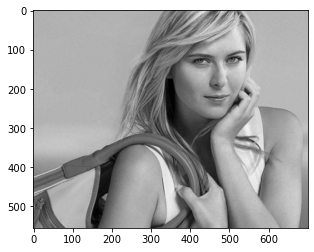

In [128]:
plt.imshow(gray, cmap='gray')

In [129]:
face_cascade = cv2.CascadeClassifier("E:/Internship project/model/opencv/haarcascades/haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("E:/Internship project/model/opencv/haarcascades/haarcascade_eye.xml")

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[352,  38, 233, 233]], dtype=int32)

In [130]:
(x,y,w,h) = faces[0]
x,y,w,h

(352, 38, 233, 233)

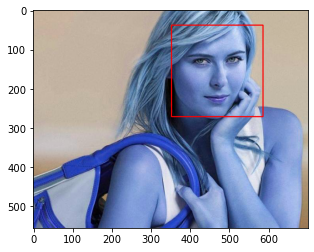

In [131]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

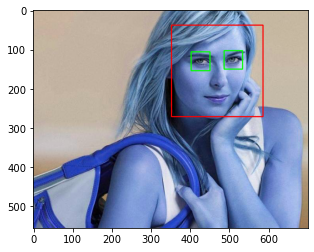

In [132]:
cv2.destroyAllWindows()
for(x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for(ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

### (2) Preprocessing: Crop the facial region of the image

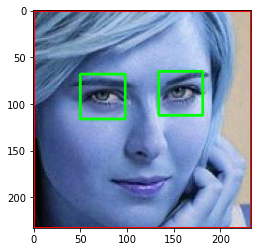

In [133]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [134]:
cropped_img = np.array(roi_color)
cropped_img.shape

(233, 233, 3)

### (3) Preprocessing: Use wavelet transform as a feature for training model

In [135]:
import numpy as np
import pywt
import cv2

def w2d(img, mode='haar' , level=1):
    imArray = img
    #convert to grayscale
    imArray = cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY)
    #convert to float
    imArray = np.float32(imArray)
    imArray /= 255;
    #compute coefficients
    coeffs=pywt.wavedec2(imArray, mode, level=level)
    
    #process coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0] *= 0;
    
    #reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H

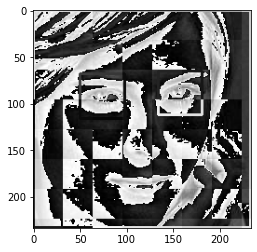

In [136]:
im_har = w2d(cropped_img, 'db1' ,5)
plt.imshow(im_har, cmap='gray')

### (3)Preprocessing:Load image,detect face if eyes >= 2 , then save and crop the face region

In [137]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for(x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

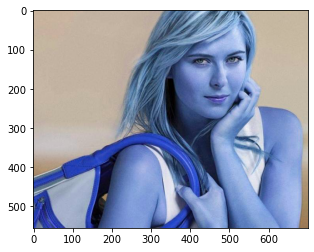

In [138]:
original_image = cv2.imread('E:/Internship project/model/test_images/sharapova1.jpg')
plt.imshow(original_image)

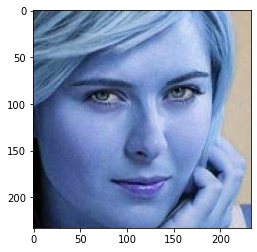

In [139]:
cropped_image = get_cropped_image_if_2_eyes('E:/Internship project/model/test_images/sharapova1.jpg')
plt.imshow(cropped_image)

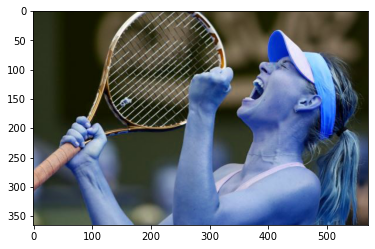

In [170]:
org_image_obstructed = cv2.imread('E:/Internship project/model/test_images/sharapova2.JPG')
plt.imshow(org_image_obstructed)

In [171]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('E:/Internship project/model/test_images/sharapova2.JPG')
cropped_image_no_2_eyes

In [184]:
path_to_data='E:/Internship project/model/dataset'
path_to_cr_data='E:/Internship project/model/dataset/cropped'

In [185]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [186]:
img_dirs

['E:/Internship project/model/dataset\\cropped',
 'E:/Internship project/model/dataset\\lionel_messi',
 'E:/Internship project/model/dataset\\maria_sharapova',
 'E:/Internship project/model/dataset\\roger_federer',
 'E:/Internship project/model/dataset\\serena_williams',
 'E:/Internship project/model/dataset\\virat_kohli']

In [187]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [188]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder:",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1
                

Generating cropped images in folder: E:/Internship project/model/dataset/croppeddataset\lionel_messi
Generating cropped images in folder: E:/Internship project/model/dataset/croppeddataset\maria_sharapova
Generating cropped images in folder: E:/Internship project/model/dataset/croppeddataset\roger_federer
Generating cropped images in folder: E:/Internship project/model/dataset/croppeddataset\serena_williams
Generating cropped images in folder: E:/Internship project/model/dataset/croppeddataset\virat_kohli


In [202]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'croppeddataset\\lionel_messi': ['E:/Internship project/model/dataset/croppeddataset\\lionel_messi\\lionel_messi1.png',
  'E:/Internship project/model/dataset/croppeddataset\\lionel_messi\\lionel_messi10.png',
  'E:/Internship project/model/dataset/croppeddataset\\lionel_messi\\lionel_messi11.png',
  'E:/Internship project/model/dataset/croppeddataset\\lionel_messi\\lionel_messi12.png',
  'E:/Internship project/model/dataset/croppeddataset\\lionel_messi\\lionel_messi13.png',
  'E:/Internship project/model/dataset/croppeddataset\\lionel_messi\\lionel_messi14.png',
  'E:/Internship project/model/dataset/croppeddataset\\lionel_messi\\lionel_messi15.png',
  'E:/Internship project/model/dataset/croppeddataset\\lionel_messi\\lionel_messi16.png',
  'E:/Internship project/model/dataset/croppeddataset\\lionel_messi\\lionel_messi17.png',
  'E:/Internship project/model/dataset/croppeddataset\\lionel_messi\\lionel_messi18.png',
  'E:/Internship project/model/dataset/croppeddataset\\lionel_messi\\

In [211]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'croppeddataset\\lionel_messi': 0,
 'croppeddataset\\maria_sharapova': 1,
 'croppeddataset\\roger_federer': 2,
 'croppeddataset\\serena_williams': 3,
 'croppeddataset\\virat_kohli': 4}

In [212]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32,32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [213]:
len(X[0])

4096

In [214]:
32*32*3 + 32*32

4096

In [215]:
X[0]

array([[100],
       [129],
       [140],
       ...,
       [237],
       [234],
       [232]], dtype=uint8)

In [216]:
y[0]

0

In [218]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(191, 4096)

In [221]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc',SVC(kernel = 'rbf', C=10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7083333333333334

In [225]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.78      0.78      0.78         9
           2       0.40      0.50      0.44         4
           3       0.86      0.46      0.60        13
           4       0.63      1.00      0.77        12

    accuracy                           0.71        48
   macro avg       0.71      0.69      0.67        48
weighted avg       0.75      0.71      0.70        48



### Gridsearch 

In [226]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [246]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C' : [1,10,100,1000],
            'svc__kernel' : ['rbf','linear']
        }
    },
    'random_forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model' : LogisticRegression(solver='liblinear' ,multi_class='auto'),
        'params' : {
            'logisticregression__C' : [1,5,10]
        }
    }
}

In [247]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model' : algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.753941,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.650000,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.824138,{'logisticregression__C': 1}


In [250]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [251]:
best_estimators['svm'].score(X_test,y_test)

0.6875

In [252]:
best_estimators['random_forest'].score(X_test,y_test)

0.6458333333333334

In [255]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7916666666666666

In [257]:
best_clf = best_estimators['svm']

In [258]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 7,  0,  1,  0,  2],
       [ 0,  7,  1,  0,  1],
       [ 0,  0,  2,  2,  0],
       [ 1,  3,  2,  7,  0],
       [ 0,  0,  1,  1, 10]], dtype=int64)

Text(69.0, 0.5, 'Truth')

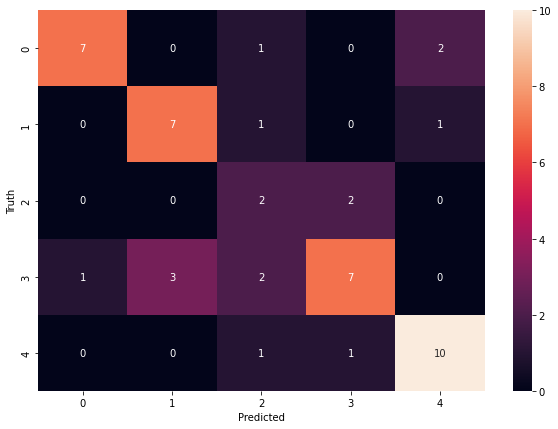

In [260]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [261]:
class_dict

{'croppeddataset\\lionel_messi': 0,
 'croppeddataset\\maria_sharapova': 1,
 'croppeddataset\\roger_federer': 2,
 'croppeddataset\\serena_williams': 3,
 'croppeddataset\\virat_kohli': 4}

### Saving trained model

In [262]:
!pip install joblib
import joblib
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

### Save class dictionary

In [263]:
import json
with open("class_dictionaryy.json","w") as f:
    f.write(json.dumps(class_dict))